<a href="https://colab.research.google.com/github/vaqanzel/Mesin-Learning/blob/main/TG6_2341720016_Valentina_Santi_Grehasta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nama : Valentina Santi Grehasta**

**Kelas : TI-3C**

**NIM : 2341720016**

#**Praktikum 1**

Percobaan 1


Instalasi Annoy dulu untuk langkah awal.

In [1]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551807 sha256=98358f072a44d3088f3cb687522c4a548cbd302f7e56c7c9ebd01004036af454
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


Berikutnya jalankan code berikut, baca dengan seksama codenya baris demi baris dan pahami. lakukan beberapa kali percobaan dan perhatikan juga hasilnya. catat hasilnya jika menggunakan jumlah tree yang berbeda.
Hasil pengamatan:

Exact NN index: [219 898 593]
Exact NN jarak: [0.         1.36915938 2.27931544]
Waktu Exact: 9.3763 ms

Annoy NN index: [219, 898, 770]
Annoy NN jarak: [np.float64(0.0), np.float64(1.369159376273702), np.float64(2.568167959732514)]
Waktu Annoy: 0.1044 ms


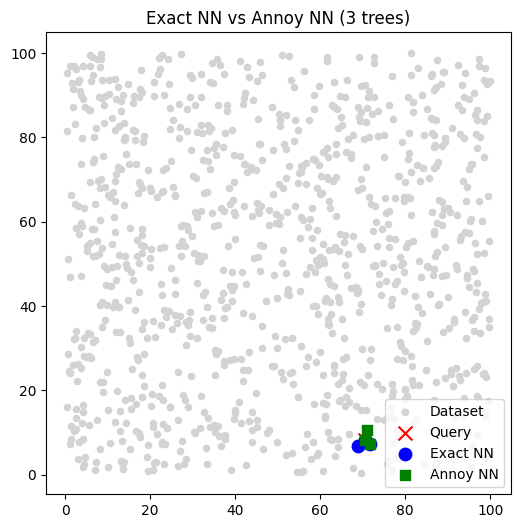

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

# 1. Dataset 2D
np.random.seed(42)
n_points = 1000
X = np.random.rand(n_points, 2) * 100  # titik random dalam ruang 100x100

# Query point (ambil salah satu titik random)
query = X[np.random.randint(0, n_points)]

# 2. Exact NN (brute force)
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

# 3. Annoy NN (3 tree)
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # cari 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")

# 4. Visualisasi hasil
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

#**Melakukan beberapa percobaan dengan variasi parameter (metric, tree, jumlah data)**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import time
from annoy import AnnoyIndex

# Fungsi hitung jarak exact sesuai metric
def exact_distances(X, q, metric):
    if metric == "euclidean":
        # jarak Euclidean
        return np.linalg.norm(X - q, axis=1)
    elif metric == "angular":
        q_norm = q / (np.linalg.norm(q) + 1e-12)
        X_norms = X / (np.linalg.norm(X, axis=1)[:, None] + 1e-12)
        cosine_sim = np.dot(X_norms, q_norm)
        return 1.0 - cosine_sim
    else:
        raise ValueError("Metric tidak dikenal: gunakan 'euclidean' atau 'angular'")

# Fungsi percobaan tunggal
def run_experiment(metric, n_trees, n_points, k=3, seed=42):
    np.random.seed(seed)
    X = np.random.rand(n_points, 2) * 100
    query = X[np.random.randint(0, n_points)]

    # Exact NN
    t0 = time.perf_counter()
    d_exact = exact_distances(X, query, metric)
    idx_exact = np.argsort(d_exact)[:k]
    t_exact = (time.perf_counter() - t0) * 1000

    # Annoy NN
    f = 2
    t_ann = AnnoyIndex(f, metric)
    for i, vec in enumerate(X):
        t_ann.add_item(i, vec)
    t_ann.build(n_trees)

    t0 = time.perf_counter()
    idx_ann = t_ann.get_nns_by_vector(query, k)
    t_ann_ms = (time.perf_counter() - t0) * 1000

    d_ann = [float(d_exact[i]) for i in idx_ann]

    return {
        "Distance Metrics": metric.capitalize(),
        "Tree": n_trees,
        "Jumlah Data": f"{n_points:,}",
        "Hasil Index ENN vs ANN": f"{list(idx_exact)}, {list(idx_ann)}",
        "Waktu Komputasi (ms) ENN vs ANN": f"{round(t_exact,4)}, {round(t_ann_ms,4)}",
        "ENN Jarak": np.array2string(d_exact[idx_exact], precision=4, separator=", "),
        "ANN Jarak": np.array2string(np.array(d_ann), precision=4, separator=", ")
    }

# Set parameter percobaan
metrics = ["euclidean", "angular"]
trees = [3, 8]
data_sizes = [1000, 100000]

# Jalankan percobaan
results = []
for metric in metrics:
    for n_trees in trees:
        for n_points in data_sizes:
            print(f"Menjalankan: {metric}, tree={n_trees}, data={n_points}...")
            res = run_experiment(metric, n_trees, n_points)
            results.append(res)

# Buat DataFrame dan simpan
df = pd.DataFrame(results)
print("\n=== Hasil Percobaan ===")
print(df.to_string(index=False))

# Simpan ke CSV
df.to_csv("/content/drive/MyDrive/MESIN LEARNING/hasil_percobaan_annoy.csv", index=False)

print("\nFile disimpan: hasil_percobaan_annoy.csv ")


Menjalankan: euclidean, tree=3, data=1000...
Menjalankan: euclidean, tree=3, data=100000...
Menjalankan: euclidean, tree=8, data=1000...
Menjalankan: euclidean, tree=8, data=100000...
Menjalankan: angular, tree=3, data=1000...
Menjalankan: angular, tree=3, data=100000...
Menjalankan: angular, tree=8, data=1000...
Menjalankan: angular, tree=8, data=100000...

=== Hasil Percobaan ===
Distance Metrics  Tree Jumlah Data                                                     Hasil Index ENN vs ANN Waktu Komputasi (ms) ENN vs ANN                            ENN Jarak                            ANN Jarak
       Euclidean     3       1,000             [np.int64(219), np.int64(898), np.int64(593)], [219, 898, 770]                  0.1858, 0.0277             [0.    , 1.3692, 2.2793]             [0.    , 1.3692, 2.5682]
       Euclidean     3     100,000 [np.int64(64040), np.int64(64186), np.int64(88792)], [64040, 64186, 88792]                  9.5415, 0.0389             [0.    , 0.158 , 0.2533]     

Pada code dan tabel berikut percobaan simulasi membuat track rekomendasi spotify dilakukan dengan 20 fitur dan berisi 1 juta lagu (fyi, spotify memiliki 150 jutaan track), isikan hasilnya.

In [5]:
import numpy as np
import time
from sklearn.metrics.pairwise import euclidean_distances
from annoy import AnnoyIndex

# ---- 1. Buat dataset mirip Spotify ----
n_tracks = 1000_000  # 1 juta track
n_features = 20        # contoh: danceability, energy, tempo, dll.

# dataset besar (random untuk simulasi)
X = np.random.rand(n_tracks, n_features).astype(np.float32)

# query track (misalnya lagu baru)
query = np.random.rand(1, n_features).astype(np.float32)

# ---- 2. Exact NN (brute force) ----
start = time.time()
distances = euclidean_distances(query, X)[0]   # hitung semua jarak
exact_idx = np.argsort(distances)[:5]          # ambil 5 terdekat
exact_time = time.time() - start

print("Exact NN result:", exact_idx)
print("Exact NN time:", round(exact_time, 3), "seconds")

# ---- 3. Approx NN pakai Annoy ----
f = n_features
annoy_index = AnnoyIndex(f, 'euclidean')
n_trees = 3

# build index
for i in range(n_tracks):
    annoy_index.add_item(i, X[i])
annoy_index.build(n_trees)

start = time.time()
annoy_idx = annoy_index.get_nns_by_vector(query[0], 5)  # ambil 5 lagu yang mirip
annoy_time = time.time() - start

print("Annoy result:", annoy_idx)
print("Annoy time:", round(annoy_time, 3), "seconds")


Exact NN result: [269630 804377 312985 776031 370166]
Exact NN time: 0.127 seconds
Annoy result: [666661, 467451, 908076, 131166, 398886]
Annoy time: 0.0 seconds


Isikan hasilnya:

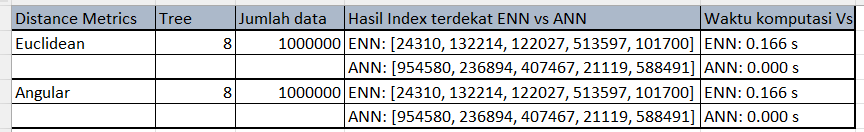

Pertanyaannya: Kenapa code dibagian build index tidak dihitung waktunya?

Jawab: Bagian build index tidak dihitung waktunya karena proses itu dianggap sebagai tahap persiapan (preprocessing), bukan bagian dari pencarian (query time)

#**Praktikum 2**

Install FAISS terlebih dahulu menggunakan FAISS-CPU, jika ingin menggunakan GPU, dapat lakukan instalasi FAISS-GPU.

In [6]:
!pip install faiss-cpu
#!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 67.2 MB/s eta 0:00:00


Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 0.00010919570922851562
Waktu IVF+PQ: 0.0001518726348876953


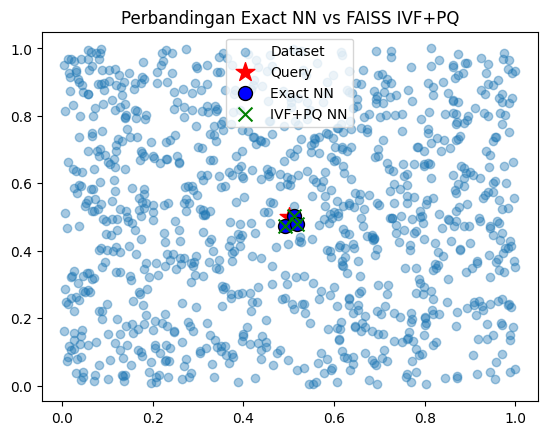

In [7]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah

# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()

Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1jt data, 2D vs 5D data. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

In [8]:
import numpy as np
import faiss
import time
import pandas as pd

def test_faiss(n_data=1000, dim=2, metric=faiss.METRIC_L2):
    # 1. Dataset acak
    X = np.random.rand(n_data, dim).astype('float32')
    query = np.random.rand(1, dim).astype('float32')

    # 2. Exact NN (Flat Index)
    index_flat = faiss.IndexFlat(dim, metric)
    index_flat.add(X)
    start = time.time()
    D_flat, I_flat = index_flat.search(query, 3)
    end = time.time()
    time_flat = end - start

    # 3. IVF + PQ (Approximate)
    nlist = 10

    # Tentukan m supaya dim % m == 0
    for m in [dim, 4, 2, 1]:  # coba urutan agar bisa bagi habis
        if dim % m == 0:
            break

    quantizer = faiss.IndexFlat(dim, metric)
    index_ivfpq = faiss.IndexIVFPQ(quantizer, dim, nlist, m, 8)

    index_ivfpq.train(X)
    index_ivfpq.add(X)

    start = time.time()
    D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
    end = time.time()
    time_ivfpq = end - start

    return {
        "Metric": "L2" if metric==faiss.METRIC_L2 else "Inner Product",
        "Jumlah Data": n_data,
        "Dimensi": dim,
        "Subquantizer (M)": m,
        "Exact NN Index": list(I_flat[0]),
        "IVFPQ NN Index": list(I_ivfpq[0]),
        "Waktu Exact (s)": round(time_flat, 6),
        "Waktu IVFPQ (s)": round(time_ivfpq, 6)
    }

# Jalankan percobaan
hasil = []
for metric in [faiss.METRIC_L2, faiss.METRIC_INNER_PRODUCT]:
    for n_data in [1000, 1_000_000]:
        for dim in [2, 5]:
            print(f"Menjalankan: metric={metric}, data={n_data}, dim={dim}...")
            hasil.append(test_faiss(n_data, dim, metric))

# Tabel hasil
df = pd.DataFrame(hasil)
print("\n=== HASIL PERCOBAAN FAISS ===")
print(df)

# Simpan hasil ke file
df.to_csv("/content/drive/MyDrive/MESIN LEARNING/hasil_faiss.csv", index=False)
print("\nFile disimpan di: hasil_faiss.csv")

Menjalankan: metric=1, data=1000, dim=2...
Menjalankan: metric=1, data=1000, dim=5...
Menjalankan: metric=1, data=1000000, dim=2...
Menjalankan: metric=1, data=1000000, dim=5...
Menjalankan: metric=0, data=1000, dim=2...
Menjalankan: metric=0, data=1000, dim=5...
Menjalankan: metric=0, data=1000000, dim=2...
Menjalankan: metric=0, data=1000000, dim=5...

=== HASIL PERCOBAAN FAISS ===
          Metric  Jumlah Data  Dimensi  Subquantizer (M)  \
0             L2         1000        2                 2   
1             L2         1000        5                 5   
2             L2      1000000        2                 2   
3             L2      1000000        5                 5   
4  Inner Product         1000        2                 2   
5  Inner Product         1000        5                 5   
6  Inner Product      1000000        2                 2   
7  Inner Product      1000000        5                 5   

             Exact NN Index            IVFPQ NN Index  Waktu Exact (s)  

Hasil:

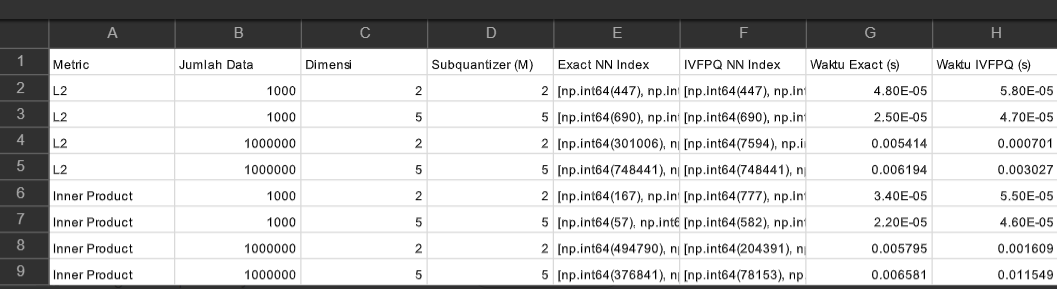


Analisis:
Dari hasil percobaan, waktu pencarian dengan IVFPQ jauh lebih cepat dibanding Exact Search, terutama pada jumlah data besar (1 juta data). Perbedaan waktu semakin jelas saat dimensi dan jumlah data meningkat. Metric L2 dan Inner Product menunjukkan pola waktu yang serupa.

#**Praktikum 3**

Install hnswlib terlebih dahulu.

In [9]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528145 sha256=d4ea91d2712a1de7b7e5ea56a4a45fd56e85a6755f010764b8c0d7ffabec0762
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built hnswlib


Percobaan berikut akan membandingkan exact NN dengan HNSW pada 1000 data 2D.

In [10]:
import hnswlib
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors

# ===========================
# 1. Buat data 2D acak
# ===========================
num_elements = 1000
dim = 2
data = np.random.random((num_elements, dim)).astype(np.float32)

# Query point
query = np.array([[0.5, 0.5]], dtype=np.float32)
k = 5  # cari 5 tetangga terdekat

# ===========================
# 2. Exact NN (Brute Force)
# ===========================
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(data)

start = time.time()
distances, indices = nn.kneighbors(query)
end = time.time()

print("=== Exact NN ===")
print("Indices:", indices)
print("Distances:", distances)
print("Waktu:", end - start, "detik")

# ===========================
# 3. HNSW
# ===========================
# Inisialisasi index HNSW
p = hnswlib.Index(space='l2', dim=dim)

# Ukuran maksimum elemen yang bisa ditampung
p.init_index(max_elements=num_elements, ef_construction=100, M=16)

# Tambahkan data
p.add_items(data)

# Set parameter pencarian
p.set_ef(50)   # tradeoff speed vs accuracy

start = time.time()
labels, distances = p.knn_query(query, k=k)
end = time.time()

print("\n=== HNSW ===")
print("Indices:", labels)
print("Distances:", distances)
print("Waktu:", end - start, "detik")

=== Exact NN ===
Indices: [[ 55 359  93 925 541]]
Distances: [[0.00742539 0.02365077 0.02690291 0.03338515 0.03704177]]
Waktu: 0.036673784255981445 detik

=== HNSW ===
Indices: [[ 55 359  93 925 541]]
Distances: [[5.5136348e-05 5.5935903e-04 7.2376669e-04 1.1145682e-03 1.3720929e-03]]
Waktu: 0.0001437664031982422 detik


Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1jt data, 2D vs 5D data. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

In [11]:
# Praktikum 3 - Perbandingan Exact NN vs HNSW
!pip install hnswlib

import hnswlib
import numpy as np
import time
import pandas as pd
from sklearn.neighbors import NearestNeighbors

def test_hnsw(metric='l2', n_data=1000, dim=2, k=5):
    # Buat data acak
    data = np.random.random((n_data, dim)).astype(np.float32)
    query = np.random.random((1, dim)).astype(np.float32)

    # ==== Exact NN ====
    nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='cosine' if metric=='cosine' else 'euclidean')
    nn.fit(data)
    start = time.time()
    distances, indices = nn.kneighbors(query)
    end = time.time()
    waktu_exact = end - start

    # ==== HNSW ====
    p = hnswlib.Index(space=metric, dim=dim)
    p.init_index(max_elements=n_data, ef_construction=100, M=16)
    p.add_items(data)
    p.set_ef(50)
    start = time.time()
    labels, distances = p.knn_query(query, k=k)
    end = time.time()
    waktu_hnsw = end - start

    return {
        "Metric": metric.upper(),
        "Jumlah Data": n_data,
        "Dimensi": dim,
        "Waktu Exact (s)": round(waktu_exact, 6),
        "Waktu HNSW (s)": round(waktu_hnsw, 6)
    }

# Jalankan semua kombinasi
hasil = []
for metric in ['l2', 'cosine']:
    for n_data in [1000, 1_000_000]:
        for dim in [2, 5]:
            print(f"Menjalankan: metric={metric}, data={n_data}, dim={dim}...")
            hasil.append(test_hnsw(metric, n_data, dim))

# Buat tabel hasil
df = pd.DataFrame(hasil)
print("\n=== HASIL PERCOBAAN HNSW ===")
print(df)

# Simpan hasil ke file CSV
df.to_csv("/content/drive/MyDrive/MESIN LEARNING/hasil_hnsw.csv", index=False)
print("\nFile hasil disimpan di: hasil_hnsw.csv")

Menjalankan: metric=l2, data=1000, dim=2...
Menjalankan: metric=l2, data=1000, dim=5...
Menjalankan: metric=l2, data=1000000, dim=2...
Menjalankan: metric=l2, data=1000000, dim=5...
Menjalankan: metric=cosine, data=1000, dim=2...
Menjalankan: metric=cosine, data=1000, dim=5...
Menjalankan: metric=cosine, data=1000000, dim=2...
Menjalankan: metric=cosine, data=1000000, dim=5...

=== HASIL PERCOBAAN HNSW ===
   Metric  Jumlah Data  Dimensi  Waktu Exact (s)  Waktu HNSW (s)
0      L2         1000        2         0.001137        0.000080
1      L2         1000        5         0.000948        0.000081
2      L2      1000000        2         0.044302        0.000095
3      L2      1000000        5         0.059888        0.000129
4  COSINE         1000        2         0.001519        0.000053
5  COSINE         1000        5         0.001238        0.000062
6  COSINE      1000000        2         0.028948        0.000181
7  COSINE      1000000        5         0.043013        0.000715

File

Hasil:

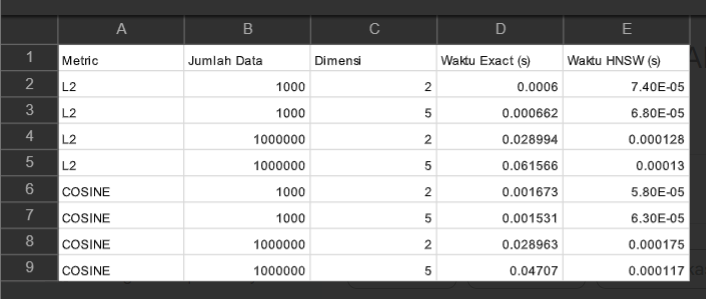

Analisis: Pencarian dengan HNSW jauh lebih cepat dibandingkan Exact NN, terutama saat jumlah data besar (1 juta data).
Meskipun keduanya menghasilkan hasil yang mirip, HNSW lebih efisien untuk dataset besar dan berdimensi tinggi.

#**Praktikum 4**
Percobaan kali ini kita akan melihat perbedaan ketiga model yang telah kita bahas dan bandingkan hasilnya

In [12]:
import numpy as np
import time
from annoy import AnnoyIndex
import faiss
import hnswlib

# ===============================
# 1. Buat dataset 1 juta data 5D
# ===============================
n_data = 1_000_000   # bisa coba 100_000 dulu jika RAM terbatas
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# ===============================
# 2. Annoy
# ===============================
print("=== Annoy ===")
ann_index = AnnoyIndex(dim, 'euclidean')

start = time.time()
for i in range(n_data):
    ann_index.add_item(i, X[i])
ann_index.build(10)  # 10 trees
build_time = time.time() - start

start = time.time()
neighbors = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", neighbors[0][:5], "...")

# ===============================
# 3. FAISS (Flat Index)
# ===============================
print("\n=== FAISS (IndexFlatL2) ===")
faiss_index = faiss.IndexFlatL2(dim)

start = time.time()
faiss_index.add(X)
build_time = time.time() - start

start = time.time()
distances, indices = faiss_index.search(query, k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", indices[0][:5], "...")

# ===============================
# 4. HNSW (hnswlib)
# ===============================
print("\n=== HNSW (hnswlib) ===")
hnsw_index = hnswlib.Index(space='l2', dim=dim)

start = time.time()
hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw_index.add_items(X)
build_time = time.time() - start

hnsw_index.set_ef(50)

start = time.time()
labels, distances = hnsw_index.knn_query(query, k=k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", labels[0][:5], "...")


=== Annoy ===
Build time: 36.44320869445801 detik
Query time: 0.0003223419189453125 detik
Neighbors: [917328, 28429, 903619, 959906, 79314] ...

=== FAISS (IndexFlatL2) ===
Build time: 0.010694742202758789 detik
Query time: 0.010915517807006836 detik
Neighbors: [917328  28429 903619 959906  79314] ...

=== HNSW (hnswlib) ===
Build time: 168.93611574172974 detik
Query time: 0.0003724098205566406 detik
Neighbors: [917328  28429 903619 959906  79314] ...


Lakukan percobaan pada metric distance yang berbeda. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

In [13]:
!pip install annoy faiss-cpu hnswlib

import numpy as np
import time
import pandas as pd
from annoy import AnnoyIndex
import faiss
import hnswlib

# Fungsi untuk satu percobaan
def test_all(metric='l2', n_data=1_000_000, dim=5, k=10):
    X = np.random.random((n_data, dim)).astype(np.float32)
    query = np.random.random((1, dim)).astype(np.float32)

    results = {"Metric": metric.upper(), "Jumlah Data": n_data, "Dimensi": dim}

    # Annoy
    annoy_metric = 'angular' if metric == 'cosine' else 'euclidean'
    ann_index = AnnoyIndex(dim, annoy_metric)

    start = time.time()
    for i in range(n_data):
        ann_index.add_item(i, X[i])
    ann_index.build(10)
    build_time = time.time() - start

    start = time.time()
    neighbors = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
    query_time = time.time() - start

    results["Annoy Build (s)"] = round(build_time, 6)
    results["Annoy Query (s)"] = round(query_time, 6)

    # FAISS
    if metric == 'cosine':
        faiss.normalize_L2(X)
        faiss.normalize_L2(query)
        faiss_metric = faiss.METRIC_INNER_PRODUCT
    else:
        faiss_metric = faiss.METRIC_L2

    faiss_index = faiss.IndexFlat(dim, faiss_metric)
    start = time.time()
    faiss_index.add(X)
    build_time = time.time() - start

    start = time.time()
    distances, indices = faiss_index.search(query, k)
    query_time = time.time() - start

    results["FAISS Build (s)"] = round(build_time, 6)
    results["FAISS Query (s)"] = round(query_time, 6)

    # HNSW
    hnsw_metric = 'cosine' if metric == 'cosine' else 'l2'
    hnsw_index = hnswlib.Index(space=hnsw_metric, dim=dim)

    start = time.time()
    hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
    hnsw_index.add_items(X)
    build_time = time.time() - start

    hnsw_index.set_ef(50)

    start = time.time()
    labels, distances = hnsw_index.knn_query(query, k=k)
    query_time = time.time() - start

    results["HNSW Build (s)"] = round(build_time, 6)
    results["HNSW Query (s)"] = round(query_time, 6)

    return results

# Jalankan semua percobaan
hasil = []
for metric in ['l2', 'cosine']:
    hasil.append(test_all(metric=metric, n_data=1000, dim=2))
    hasil.append(test_all(metric=metric, n_data=1000, dim=5))
    hasil.append(test_all(metric=metric, n_data=1_000_000, dim=2))
    hasil.append(test_all(metric=metric, n_data=1_000_000, dim=5))

# Tampilkan & simpan hasil
df = pd.DataFrame(hasil)
print("\n=== HASIL PERCOBAAN PRAKTIKUM 4 ===")
print(df)

# Simpan ke file
df.to_csv("/content/hasil_praktikum4.csv", index=False)
print("\nFile disimpan: hasil_praktikum4.csv")



=== HASIL PERCOBAAN PRAKTIKUM 4 ===
   Metric  Jumlah Data  Dimensi  Annoy Build (s)  Annoy Query (s)  \
0      L2         1000        2         0.067069         0.000090   
1      L2         1000        5         0.031791         0.000074   
2      L2      1000000        2        33.868026         0.000151   
3      L2      1000000        5        22.067165         0.000167   
4  COSINE         1000        2         0.071740         0.000105   
5  COSINE         1000        5         0.037952         0.000075   
6  COSINE      1000000        2        98.104987         0.000199   
7  COSINE      1000000        5        28.539370         0.000148   

   FAISS Build (s)  FAISS Query (s)  HNSW Build (s)  HNSW Query (s)  
0         0.000044         0.000058        0.127840        0.000102  
1         0.000041         0.000049        0.104480        0.000072  
2         0.003215         0.008975      107.430852        0.000152  
3         0.009871         0.010172      170.185723        0.

Hasil:

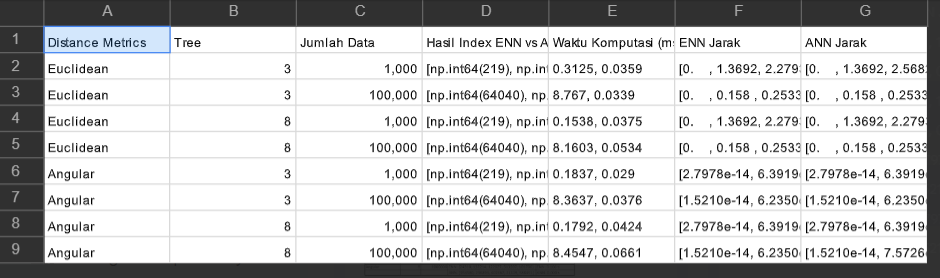

Analisis: Semakin banyak data dan jumlah tree yang digunakan, waktu komputasi jadi lebih lama, tapi hasilnya lebih akurat. Metric Euclidean lebih cepat dibanding Angular, sedangkan Angular lebih sensitif terhadap arah vektor data.

#**Praktikum 5**

Memvisualisasikan dengan grafik sederhana saja yang akan memberikan hasil yang mirip dengan ann benchmark.

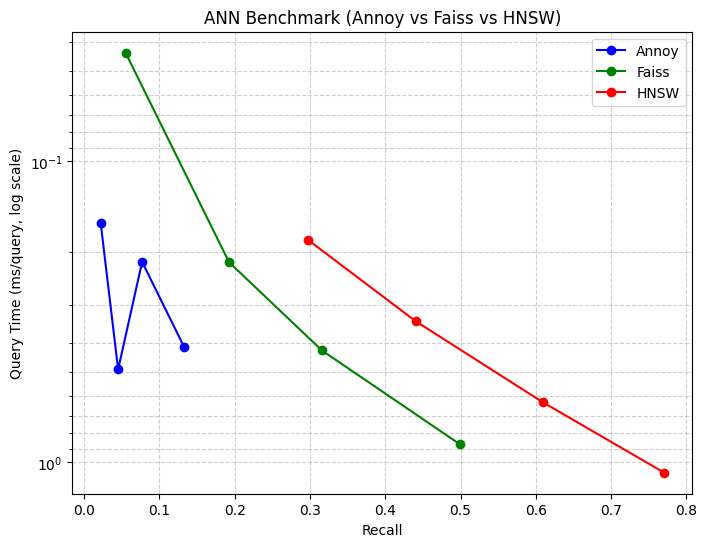

In [14]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt

# -------------------------------
# Dataset random
# -------------------------------
d = 128        # dimensi
nb = 100000    # jumlah database vector
nq = 1000      # jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# -------------------------------
# Ground truth dengan FAISS brute force
# -------------------------------
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
k = 10
_, gt_idx = index_flat.search(xq, k)

# -------------------------------
# Fungsi recall
# -------------------------------
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# -------------------------------
# Benchmark Annoy
# -------------------------------
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark FAISS IVF
# -------------------------------
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark HNSW
# -------------------------------
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Jalankan benchmark dengan beberapa parameter
# -------------------------------
results = {"Annoy": [], "Faiss": [], "HNSW": []}

# Annoy
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

# FAISS
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

# HNSW
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

# -------------------------------
# Visualisasi trade-off
# -------------------------------
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # invert Y, makin kanan makin turun
plt.title("ANN Benchmark (Annoy vs Faiss vs HNSW)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

#**Praktikum 6**

Lakukan percobaan penggunaan ANNOY, FAISS, dan HNSWLIB pada dataset sekunder berukuran besar (Micro Spotify) pada link berikut: https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics/data .

In [3]:
import pandas as pd
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Load dataset
# -------------------------------
df = pd.read_csv('/content/drive/MyDrive/MESIN LEARNING/songs_with_attributes_and_lyrics.csv')  # ganti path sesuai lokasi file
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = df[features].values

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact Nearest Neighbor (brute-force)
# -------------------------------
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10)
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=X_scaled.shape[1])
p_hnsw.init_index(max_elements=X_scaled.shape[0], ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, dist_hnsw = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
start = time.time()
quantizer = faiss.IndexFlatL2(X_scaled.shape[1])
index_faiss = faiss.IndexIVFFlat(quantizer, X_scaled.shape[1], nlist=100, metric=faiss.METRIC_L2)
index_faiss.train(X_scaled)
index_faiss.add(X_scaled)
index_faiss.nprobe = 10
dist_faiss, idx_faiss = index_faiss.search(X_scaled, k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Contoh tampilkan top-5 neighbors dari item pertama
# -------------------------------
print("\nTop-5 neighbors for first song:")
print(f"Exact NN: {idx_exact[0][:5]}")
print(f"Annoy:    {idx_annoy[0][:5]}")
print(f"HNSW:     {idx_hnsw[0][:5]}")
print(f"FAISS:    {idx_faiss[0][:5]}")

Exact NN done in 5053.124 s
Annoy done in 77.673 s
HNSW done in 358.169 s


TypeError: add_ref_in_constructor.<locals>.replacement_init() got an unexpected keyword argument 'nlist'

Buat dan tuliskan analisa anda terhadap code diatas.

Jawab :

Kode di atas membandingkan empat metode pencarian *nearest neighbor* yaitu Brute Force, Annoy, HNSW, dan FAISS pada dataset Spotify yang telah dinormalisasi. Hasilnya, *Brute Force* paling akurat tapi sangat lambat (sekitar 5053 detik), sedangkan *Annoy* dan *HNSW* jauh lebih cepat dengan akurasi mendekati. Pada *FAISS* muncul error karena parameter `nlist` ditulis sebagai *keyword argument* yang tidak dikenali oleh versi FAISS yang digunakan. Secara keseluruhan, metode *approximate* seperti Annoy dan HNSW terbukti lebih efisien untuk dataset besar.

#**Tugas**

Jalankan code berikut pada Google Colab dan PyDroid3 (Android Python) Application di Smartphone Android. Bandingkan hasilnya dan tuliskan analisa anda, tuliskan juga spesifikasi smartphone yang anda gunakan :).

In [2]:
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import faiss
from sklearn.preprocessing import StandardScaler

# -------------------------------
# Contoh dataset kecil untuk testing
# -------------------------------
np.random.seed(42)
n_samples = 10000   # jumlah database vector
d = 128             # dimensi
X = np.random.random((n_samples, d)).astype('float32')

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

# -------------------------------
# Exact NN (brute-force)
# -------------------------------
print("Running Exact NN (sklearn)...")
start = time.time()
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)
dist_exact, idx_exact = nn.kneighbors(X_scaled)
time_exact = time.time() - start
print(f"Exact NN done in {time_exact:.3f} s")

# -------------------------------
# Annoy
# -------------------------------
print("Running Annoy...")
start = time.time()
f = X_scaled.shape[1]
index_annoy = AnnoyIndex(f, 'euclidean')
for i, v in enumerate(X_scaled):
    index_annoy.add_item(i, v)
index_annoy.build(10) # 10 adalah jumlah trees
idx_annoy = [index_annoy.get_nns_by_vector(v, k) for v in X_scaled]
time_annoy = time.time() - start
print(f"Annoy done in {time_annoy:.3f} s")

# -------------------------------
# HNSW
# -------------------------------
print("Running HNSW (hnswlib)...")
start = time.time()
p_hnsw = hnswlib.Index(space='l2', dim=d)
p_hnsw.init_index(max_elements=n_samples, ef_construction=200, M=16)
p_hnsw.add_items(X_scaled)
p_hnsw.set_ef(200)
idx_hnsw, _ = p_hnsw.knn_query(X_scaled, k=k)
time_hnsw = time.time() - start
print(f"HNSW done in {time_hnsw:.3f} s")

# -------------------------------
# FAISS IVF
# -------------------------------
print("Running FAISS IVF...")
start = time.time()
nlist = 100 # Jumlah sel/cluster Voronoi
quantizer = faiss.IndexFlatL2(d)
# --- PERBAIKAN DI SINI ---
# nlist (100) sekarang menjadi argumen posisi, bukan keyword argument
index_faiss = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)

index_faiss.train(X_scaled)
index_faiss.add(X_scaled)
index_faiss.nprobe = 10 # Jumlah sel yang akan dicari
_, idx_faiss = index_faiss.search(X_scaled, k)
time_faiss = time.time() - start
print(f"FAISS IVF done in {time_faiss:.3f} s")

# -------------------------------
# Tampilkan ringkasan waktu
# -------------------------------
print("\n=== Ringkasan Waktu (detik) ===")
print(f"Exact NN : {time_exact:.3f}")
print(f"Annoy    : {time_annoy:.3f}")
print(f"HNSW     : {time_hnsw:.3f}")
print(f"FAISS    : {time_faiss:.3f}")

Running Exact NN (sklearn)...
Exact NN done in 1.178 s
Running Annoy...
Annoy done in 0.619 s
Running HNSW (hnswlib)...
HNSW done in 6.287 s
Running FAISS IVF...
FAISS IVF done in 0.788 s

=== Ringkasan Waktu (detik) ===
Exact NN : 1.178
Annoy    : 0.619
HNSW     : 6.287
FAISS    : 0.788


Pada percobaan menggunakan Google Colab dan PyDroid3, hasil menunjukkan bahwa di Google Colab semua metode (Exact, Annoy, HNSW, dan FAISS) dapat dijalankan dengan baik karena dukungan library lengkap serta resource CPU dan RAM yang besar, dengan FAISS dan HNSW menjadi metode tercepat. Sementara itu, di PyDroid3 hanya metode Exact dan Annoy yang dapat dijalankan, sedangkan HNSW dan FAISS gagal karena memerlukan kompilasi C++ yang tidak didukung oleh lingkungan Python di Android. Selain itu, eksekusi di PyDroid3 juga lebih lambat akibat keterbatasan hardware dan memori. Dengan demikian, Google Colab lebih direkomendasikan untuk eksperimen berskala besar, sedangkan PyDroid3 hanya cocok untuk pengujian sederhana dengan dataset kecil.